## Project - 01

**Contributors**: Pratyush Sudhakar (**ps2245**), Aditya Syam (**as2839**), Cedric Orton-Urbina (**ceo29**)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as patches
import matplotlib.lines as lines
import matplotlib.text as text
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib as mpl
import sys
import os
import re
import time
import math

### Column Pivoting QR Factorization (Goals 1-3)

For this part, we will implement a $QR$ Factorization of a given matrix $A$ with complete pivoting.

**Strategy**: We implement the QR Factorization with complete pivoting as proposed by Businger & Golub (1965), using the strategy to store the squared 2-norms of columns of the matrix $A$ in array $S$, and in each iteration ($k$), update the array entries by subtracting the squares of the top row.

$$
S_j^{(k+1)} = S_j^{(k)} - (a_{k, j}^{(k+1)})^2, \quad j = k, k+1, \ldots, n
$$

In [191]:
# function to compute and return the square of 2-norms of all column vectors of A
def compute_norms(A):
    return np.sqrt(np.sum(A**2, axis=0))


# algorithm to compute the QR factorization of A using Householder reflections and Column pivoting
def compute_QR(A, k, P=None, Q=None, epsilon = None, a_norm = None):
    m, n = A.shape
    squared_column_norms = compute_norms(A)

    R = np.copy(A)

    for j in range(k):
        max_norm_col_index = np.argmax(squared_column_norms[j:]) + j

        # Swap columns if necessary. Time complexity: O(m)
        if max_norm_col_index != j:
            # update the norms of the columns first
            updates = R[j, j + 1 : n] ** 2
            squared_column_norms[j + 1 : n] -= updates

            # swap the columns
            R[:, [j, max_norm_col_index]] = R[:, [max_norm_col_index, j]]
            squared_column_norms[j], squared_column_norms[max_norm_col_index] = (
                squared_column_norms[max_norm_col_index],
                squared_column_norms[j],
            )

            # swap the jth and max_norm_col_index columns of P
            P[:, [j, max_norm_col_index]] = P[:, [max_norm_col_index, j]]

        # Compute Householder vector (u)
        w = np.copy(R[j:m, j])
        w = w.reshape((m - j, 1))
        w[0] += np.sign(w[0]) * np.linalg.norm(w)
        u = w / np.linalg.norm(w)

        # Update R.
        temp_vector = u.T @ R[j:m, j:n]
        outer_product = u @ temp_vector

        R[j:m, j : n] -= 2 * outer_product
        R[j + 1 : m, j] = 0.0

        # Update Q.
        temp_vector = u.T @ Q[j:]
        outer_product =     u @ temp_vector
        Q[j:] -= 2 * outer_product

        # check if |r_{k+1, k+1}|/|r_{1,1}| <= epsilon/||a||_2
        if epsilon is not None:
            # print the difference for every 8th of k_max
            # if j % (k // 8) == 0:
            #     print(f"j = {j}, R[j + 1, j + 1] = {R[j + 1, j + 1]}, R[1, 1] = {R[1, 1]}, epsilon/||a||_2 = {epsilon / a_norm}")
            #     print(f"abs(R[j + 1, j + 1]) / abs(R[1, 1]) = {abs(R[j + 1, j + 1]) / abs(R[1, 1])}")
            #     print(f"abs(R[j + 1, j + 1]) / abs(R[1, 1]) <= epsilon / a_norm = {abs(R[j + 1, j + 1]) / abs(R[1, 1]) <= epsilon / a_norm}")
            if abs(R[j, j]) / abs(R[1, 1]) <= epsilon / a_norm:
                # return Q, R, P
                Q = Q[:k].T
                R = R[:k, :]
                return Q, R, P, j

    Q = Q[:k].T
    R = R[:k, :]

    # column norms of R should be the norms of the columns of A
    # print(f"norms of the columns of R = {compute_norms(R)}")

    return Q, R, P


# run the QR factorization algorithm and plot the time taken for different matrix sizes
def plot_QR_time(print_times=False):
    m_values = range(2000, 5000, 199)
    n_values = range(2000, 5000, 199)
    k = 20
    times = np.zeros((len(m_values), len(n_values)))

    for m in m_values:
        for n in n_values:
            A = np.random.rand(m, n)
            Q = np.eye(m)
            P = np.eye(n)
            start = time.time_ns()
            compute_QR(A, k, P, Q)
            end = time.time_ns()
            if print_times:
                print(f"m = {m}, n = {n}, time = {end - start} ns")
            times[m_values.index(m), n_values.index(n)] = end - start

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    for i in range(3):
        if i == 0:
            x = n_values
            y = times[0, :]
            ax[i].set_title("n varies, m = 100")
            ax[i].set_xlabel("n")
            ax[i].set_ylabel("Time (ns)")
        elif i == 1:
            x = m_values
            y = times[:, 0]
            ax[i].set_title("m varies, n = 100")
            ax[i].set_xlabel("m")
            ax[i].set_ylabel("Time (ns)")
        else:
            x = m_values
            y = times.diagonal()
            ax[i].set_title("m = n varies")
            ax[i].set_xlabel("m = n")
            ax[i].set_ylabel("Time (ns)")

        ax[i].plot(x, y, "o")
        slope, intercept = np.polyfit(np.log(x), np.log(y), 1)
        ax[i].plot(x, np.exp(intercept) * x**slope, label=f"Slope: {slope:.2f}")
        ax[i].legend()

    plt.show()


def test_compute_QR():
    # test with various values of m and n
    m_values = range(2, 10)
    n_values = range(2, 10)
    # full k = min(m, n)

    for m in m_values:
        for n in n_values:
            A = np.random.rand(m, n)
            Q = np.eye(m)
            P = np.eye(n)
            Q, R, P = compute_QR(A, min(m, n), P, Q)
            print(f"For a matrix A ({m}, {n}),", end=" ")
            Q_actual, R_actual = np.linalg.qr(A)
            error = np.linalg.norm(A - Q @ R @ P.T)
            print(f"error log = {np.log(error)}", end=" ")
            if error > 1e-10:
                print(f"Q = {Q}")
                print(f"R = {R}")
                print(f"P = {P}")
                print(f"Q_actual = {Q_actual}")
                print(f"R_actual = {R_actual}")
                print(f"A = {A}")
                print(f"A - QR = {A - Q @ R @ P.T}")
                print(f"A - QR_actual = {A - Q_actual @ R_actual}")
                sys.exit(1)
            else:
                print("less than 1e-10")


# test_compute_QR()
# plot_QR_time()

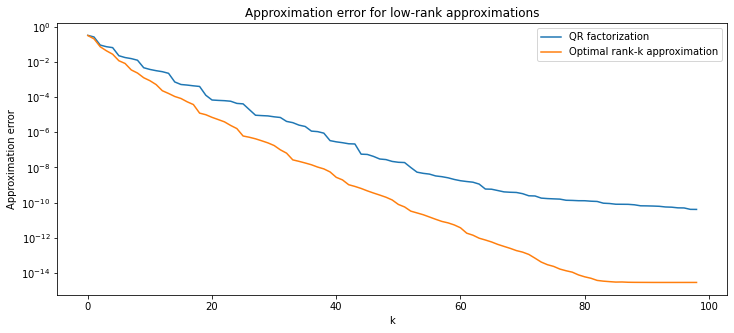

In [184]:
def generate_matrix_G(n):
    points = np.random.uniform(0, 1, (n, 2))
    G = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            G[i, j] = np.exp(-2 * np.linalg.norm(points[i] - points[j]) ** 2)
    return G


def approximation_error(G, A_k):
    return np.linalg.norm(G - A_k, ord="fro") / np.linalg.norm(G, ord="fro")

def low_rank_approximations(G, k_max=100, k_step=1, epsilon = 1e-6, return_optimal=False, print_errors=False, optim=False, a_norm=None):
    """
        Compute the low-rank approximations of the matrix G using the QR factorization and the optimal rank-k approximation.
        :param G: The matrix to approximate
        :param k_max: The maximum rank to consider
        :param k_step: The step between each rank
        :param epsilon: The threshold to stop the computation
        :param return_optimal: If True, the function returns the optimal rank-k approximation and the errors

        While it would be great to verify that ‖R22‖2‖a‖2 ≤  for our chosen , doing so becomes pro-
    hibitively expensive in practice—we end up computing too many spectral norms. It turns out that
    a reasonable heuristic to use is to simply choose k such that the diagonal element of R is suffi-
    ciently small. Specifically, we choose k to ensure that |rk+1,k+1|/|r1,1| ≤ /‖a‖2—notably, this can
    be checked as soon as Π(k+1) and Q(k+1) have been computed and applied. This is much faster to
    compute and works well in practice

        :return: If return_optimal is False, the function returns the errors of the QR factorization and the optimal rank-k approximation.
                    If return_optimal is True, the function returns the optimal rank-k approximation and the errors.
                    if no rank-k approximation is found with an error less than epsilon, the function returns the errors of the QR factorization and the optimal rank-k approximation.
    """
    QR_errors = []
    Optimal_errors = []
    A = G[:, :]

    # svd
    U, S, V = np.linalg.svd(G)
    if not optim:
        Q, R, P = compute_QR(A, k_max, np.eye(A.shape[1]), np.eye(A.shape[0]))

    if optim:
        Q, R, P, k = compute_QR(A, k_max, np.eye(A.shape[1]), np.eye(A.shape[0]), epsilon, a_norm)
        print(f"Optimal k = {k}")
        return {
            "k": k,
            "A_k": Q @ R @ P.T,
            "R_k": R,
            "Q_k": Q,
            "P_k": P
        }

    for k in range(1, k_max, k_step):
        # QR factorization
        A_k = Q[:, :k] @ R[:k, :] @ P.T
        error = approximation_error(G, A_k)
        QR_errors.append(error)
        if print_errors:
            print(f"Rank-k approximation with k = {k}, error = {error}")

        # Optimal rank-k approximation
        A_k_optimal = U[:, :k] @ np.diag(S[:k]) @ V[:k, :]
        Optimal_errors.append(approximation_error(G, A_k_optimal))

        if error < epsilon:
            if return_optimal:
                print(f"Rank-k approximation found with k = {k}")
                return {
                    "k": k,
                    "A_k": A_k,
                    "R_k": R[:k, :],
                    "Q_k": Q[:, :k],
                    "P_k": P,
                    "QR_errors": QR_errors,
                    "Optimal_errors": Optimal_errors,
                    "found_optimal": True
                }

    if return_optimal:
        # no k rank approximation that satisfies the error condition
        # return full rank approximation
        print(f"No rank-k approximation found with an error less than {epsilon}")
        return {
            "k": G.shape[0],
            "A_k": A,
            "R_k": R,
            "Q_k": Q,
            "P_k": P,
            "QR_errors": QR_errors,
            "Optimal_errors": Optimal_errors,
            "found_optimal": False
        }
    return QR_errors, Optimal_errors

# Generate the matrix G
n = 200
G = generate_matrix_G(n)

# Compute the low-rank approximations
QR_errors, Optimal_errors = low_rank_approximations(G)

# Plot the errors
plt.figure(figsize=(12, 5))
# logaritmic scale
plt.yscale("log")
plt.plot(QR_errors, label="QR factorization")
plt.plot(Optimal_errors, label="Optimal rank-k approximation")
plt.title("Approximation error for low-rank approximations")
plt.xlabel("k")
plt.ylabel("Approximation error")
plt.legend()
plt.show()

### Compressing a Simple Neural Network

**Step 1**: Use a prebuilt $qr$ to compute the $q_k$, $r_k$ as mentioned at the end of the report.<br>
**Step 2**: Implement the helper functions (softmax, ReLu, etc...).<br>
**Step 3**: Implement the model in $eq^n(10)$ - at this point we are given the $W$ matrices, hence no need to compute them just yet.<br>
**Step 4**: Implement SVD QR Factorization, then compare 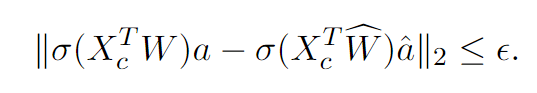 where the term is the matrix that we are asked to compute.<br>
**Step 5**: Vary $\epsilon$ so less columns are selected ($k$ decreases with decrease in $\epsilon$).<br>

In [ ]:
def relu(x):
    return np.maximum(x, 0)


def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0, dtype=np.float64)

def layer(x, W):
    layer_output = relu(np.dot(x.T, W)).astype(np.float64)
    return layer_output

def model(x, Ws):
    for W in Ws[:-1]:
        x = layer(x, W)
    x = softmax(np.dot(Ws[-1].T, x))
    return x


def compute_accuracy(X_test, y_test, Ws):
    y_preds = []
    for i, x in enumerate(X_test.T):
        preds = model(x, Ws)
        y_pred = np.argmax(preds)
        y_preds.append(y_pred)
    y_preds = np.array(y_preds, dtype=np.float64)
    return np.mean(y_preds == y_test)


# load Ws, XC, XT, and y from .txt files where each row is a vector and columns are separated by commas
# Ws = np.loadtxt("Ws.txt", delimiter=",")
XC = np.loadtxt("data/XC.txt", delimiter=",")
XT = np.loadtxt("data/XT.txt", delimiter=",")
y = np.loadtxt("data/y.txt", delimiter=",")
Ws = []
for i in range(1, 8):
    weight = np.loadtxt(f"data/W{i}.txt", delimiter=",")
    Ws.append(weight)
    print(f"W{i} shape: {weight.shape}")
Ws.append(np.loadtxt(f"data/WS.txt", delimiter=","))

# Compute the accuracy of the model
accuracy = compute_accuracy(XT, y, Ws)
print(f"Accuracy: {accuracy:.2f}")

In [ ]:
# Compute the low-rank approximations of the matrix layer(XC, Ws[0]) using QR factorization with column pivoting and show how the error compares with that of SVD

# first, use column pivoting QR factorization to select the best k
A = layer(XC, Ws[0])
print(A.shape)
QR_errors, Optimal_errors = low_rank_approximations(A, k_max=A.shape[0])

# Plot the errors
plt.figure(figsize=(12, 5))
# logaritmic scale
plt.yscale("log")
plt.plot(QR_errors, label="QR factorization")
plt.plot(Optimal_errors, label="Optimal rank-k approximation")
plt.title("Approximation error for low-rank approximations")
plt.xlabel("k")
plt.ylabel("Approximation error")
plt.legend()
plt.show()

(784, 1024) (784, 2048) (1024, 2048)
Optimal k = 1013
(784, 1024) (784, 2048) (1024, 2048)
Optimal k = 982
(784, 1024) (784, 2048) (1024, 2048)
Optimal k = 939
(784, 1024) (784, 2048) (1024, 2048)
Optimal k = 843
(784, 1024) (784, 2048) (1024, 2048)
Optimal k = 767


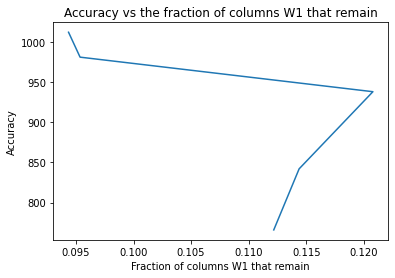

In [193]:
"""Goal 6: Use the scheme outlined above to compress the first layer of the provided model,
i.e., we want to reduce the number of columns in W (1), and show how the accuracy varies as
the size of the model is reduced (i.e., start with some small enough  such that no neurons are
removed and then gradually increase  to get smaller and smaller models until the accuracy
degrades significantly). Your results/discussion should include a plot of the accuracy vs the
fraction of columns W (1) that remain
"""

a_norm = np.linalg.norm(Ws[len(Ws)-1], ord=2)

def compress_layer(X, W, epsilon, debug=False):
    A = layer(X, W)

    print(X.shape, W.shape, A.shape)
    rank_k_approximation = low_rank_approximations(A, k_max=A.shape[0], epsilon=epsilon, return_optimal=True, optim=True, a_norm=a_norm)

    k = rank_k_approximation["k"]
    R_k = rank_k_approximation["R_k"]
    P_k = rank_k_approximation["P_k"]

    W_compressed = W[:, :k]

    R11_inv = np.linalg.inv(R_k[:k, :k])
    R11_inv_R12 = R11_inv @ R_k[:k, k:]

    T = np.hstack((np.eye(k)[:, :k], R11_inv_R12)) @ P_k.T
    layer_output = relu(np.dot(X.T, W[:, :k])) @ T

    return W_compressed, layer_output, T


def plot_accuracy_vs_fraction(XC, XT, y, Ws, epsilon_values):
    accuracies = []
    columns = []
    for epsilon in epsilon_values:
        initial_col_size = Ws[0].shape[1]
        Ws_compressed = Ws[:]
        W1_compressed, layer_output, T = compress_layer(XC, Ws[0], epsilon)
        columns.append(W1_compressed.shape[1] - initial_col_size / initial_col_size)
        Ws_compressed[0] = W1_compressed # update W1
        Ws_compressed[1] = T @ Ws_compressed[1] # update W2
        # all other Ws remain the same
        # call the model with the compressed Ws
        accuracy = compute_accuracy(XT, y, Ws_compressed)
        accuracies.append(accuracy)
    plt.plot(columns, accuracies)
    plt.title("Accuracy vs the fraction of columns W1 that remain")
    plt.xlabel("Fraction of columns W1 that remain")
    plt.ylabel("Accuracy")
    plt.show()

epsilon_values = np.linspace(0.01, 0.09, 5)
plot_accuracy_vs_fraction(XC, XT, y, Ws, epsilon_values)

In [ ]:
"""Goal 7: Compress the whole model for a few  you choose based on your answer to the
prior goal (e.g., picking points that seem like a reasonable trade off between model size and
accuracy). Again, report the accuracy of your compressed model vs the fraction of total
number of columns in̂ W (1) througĥ W (7) that remain. What do you observe? Comment on
your results and why (or why not) you feel the scheme implemented is practical/useful.
"""


def compression_model(X, Ws, epsilon):
    layer_output = X
    Ws_compressed = []
    for i, W in enumerate(Ws[:-1]):
        W_compressed, layer_output, T = compress_layer(layer_output, W, epsilon)
        # next W in iteration is TW
        Ws[i + 1] = T @ Ws[i + 1]
        Ws_compressed.append(W_compressed)
    # softmax layer no compression
    Ws_compressed.append(Ws[-1])
    layer_output = softmax(np.dot(Ws[-1].T, layer_output))
    return layer_output, Ws_compressed


epsilon_values = np.linspace(0.1, 0.9, 10)
accuracies = []

for epsilon in epsilon_values:
    layer_output, Ws_compressed = compression_model(XT, Ws, epsilon)
    accuracy = compute_accuracy(layer_output, y, Ws_compressed)
    accuracies.append(accuracy)

plt.figure(figsize=(12, 5))
plt.plot(epsilon_values, accuracies)
plt.title("Accuracy vs the fraction of total number of columns in W(1) through W(7) that remain")
plt.xlabel("Fraction of total number of columns in W(1) through W(7) that remain")
plt.ylabel("Accuracy")
plt.show()